In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima import model
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from scipy.stats import kruskal 
from statsmodels.tsa.seasonal import STL
import yfinance as yf
from scipy.signal import periodogram
import matplotlib.mlab as mlab
import matplotlib.gridspec as gridspec
import sqlite3

In [2]:
# 1 year of data in 1 hour intervals

In [3]:
rl = yf.Ticker('RL') # Ralph Lauren Corporation

In [4]:
# ['1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max']

In [5]:
rl_data = yf.download('RL', period = '1y', interval = '60m')
rl_data.to_csv('rl_data.csv')

[*********************100%***********************]  1 of 1 completed


In [6]:
rl_df = pd.read_csv('rl_data.csv')
rl_df

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-10-11 09:30:00,112.230003,113.250000,111.669998,112.629997,112.629997,146833
1,2023-10-11 10:30:00,112.559998,113.040001,112.220001,112.339996,112.339996,80800
2,2023-10-11 11:30:00,112.300003,112.565002,111.529999,111.665001,111.665001,69614
3,2023-10-11 12:30:00,111.709999,111.775002,111.120003,111.419998,111.419998,66066
4,2023-10-11 13:30:00,111.375000,112.430000,111.375000,112.279999,112.279999,78216
...,...,...,...,...,...,...,...
1751,2024-10-10 11:30:00,197.899994,198.559998,197.429993,198.235001,198.235001,37726
1752,2024-10-10 12:30:00,198.139999,198.839996,197.990005,198.360001,198.360001,56192
1753,2024-10-10 13:30:00,198.300003,198.809998,197.710007,198.100006,198.100006,44388
1754,2024-10-10 14:30:00,198.220001,198.490005,197.839996,198.350006,198.350006,94002


In [7]:
rl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1756 entries, 0 to 1755
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Datetime   1756 non-null   object 
 1   Open       1756 non-null   float64
 2   High       1756 non-null   float64
 3   Low        1756 non-null   float64
 4   Close      1756 non-null   float64
 5   Adj Close  1756 non-null   float64
 6   Volume     1756 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 96.2+ KB


In [8]:
rl_df['Datetime'].dtype

dtype('O')

In [9]:
rl_df = rl_df[['Datetime', 'Open']]

In [10]:
rl_df['Datetime'] = pd.to_datetime(rl_df['Datetime'])

C:\Users\trucn\AppData\Local\Temp\ipykernel_4980\4234641745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rl_df['Datetime'] = pd.to_datetime(rl_df['Datetime'])


In [11]:
rl_df.set_index('Datetime', inplace = True)

In [12]:
rl_df.sort_index(inplace = True)

In [13]:
rl_df_diff1 = rl_df['Open'].diff(1)

In [14]:
rl_df_diff2 = rl_df['Open'].diff(2)

In [15]:
adfuller(rl_df['Open'])

(np.float64(-1.4485755231740378),
 np.float64(0.5587798161095183),
 0,
 1755,
 {'1%': np.float64(-3.4340815615168605),
  '5%': np.float64(-2.8631882766584087),
  '10%': np.float64(-2.5676474932021653)},
 np.float64(5402.555774797071))

In [16]:
adfuller(rl_df_diff1.dropna()) # d = 1

(np.float64(-40.59110295934718),
 0.0,
 0,
 1754,
 {'1%': np.float64(-3.434083692100666),
  '5%': np.float64(-2.8631892171754747),
  '10%': np.float64(-2.5676479940036065)},
 np.float64(5400.914439443417))

In [17]:
# Use a factor of 7 (7 hours per day since that's how long the stock market is open for, and it's 5 days a week)

In [18]:
# Most seasonal period function (if it is seasonal which period most likely)

In [19]:
def find_period(signal):
    acf = np.correlate(signal, signal, 'full')[-len(signal):]
    inflection = np.diff(np.sign(np.diff(acf)))
    peaks = (inflection < 0).nonzero()[0] + 1
    return peaks[acf[peaks].argmax()]

In [20]:
rl_df.shape

(1756, 1)

In [21]:
rl_df[['Open']]

,Open
Datetime,
2023-10-11 09:30:00,112.230003
2023-10-11 10:30:00,112.559998
2023-10-11 11:30:00,112.300003
2023-10-11 12:30:00,111.709999
2023-10-11 13:30:00,111.375000
...,...
2024-10-10 11:30:00,197.899994
2024-10-10 12:30:00,198.139999
2024-10-10 13:30:00,198.300003


In [22]:
open_vals = rl_df['Open'].reset_index()

In [23]:
open_vals['Open']

0       112.230003
1       112.559998
2       112.300003
3       111.709999
4       111.375000
           ...    
1751    197.899994
1752    198.139999
1753    198.300003
1754    198.220001
1755    198.449997
Name: Open, Length: 1756, dtype: float64

(-0.1, 0.1)

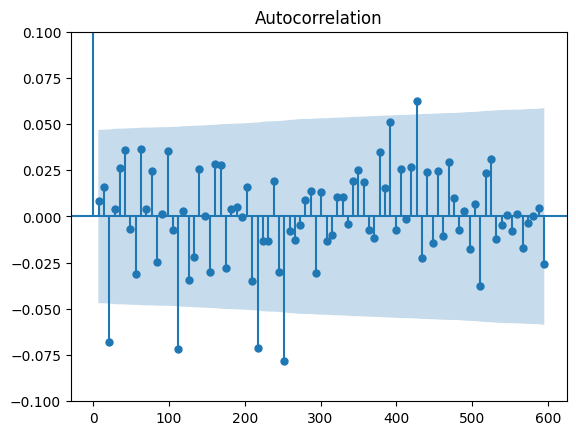

In [24]:
plot_acf(rl_df_diff1.dropna(), lags = np.arange(0, 600, 7)); # q = 1 # look at first 600 lags, every 7
plt.ylim(-0.1,0.1)

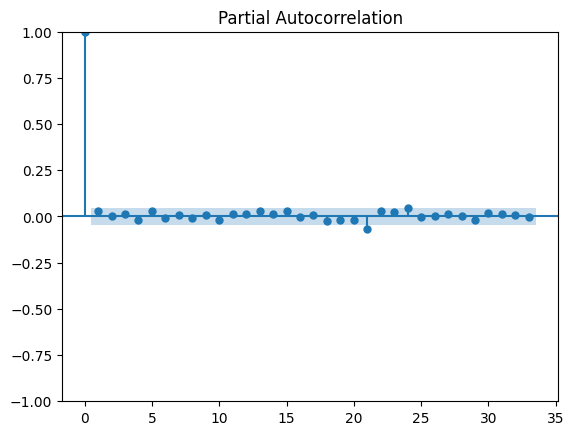

In [25]:
plot_pacf(rl_df_diff1.dropna()); # p = 1

# Do ARIMA if data has no seasonality

In [26]:
rl_group = [rl_df.iloc[i::7] for i in range(7)] # 7 because it's 7 hours each day
rl_group

[                           Open
 Datetime                       
 2023-10-11 09:30:00  112.230003
 2023-10-12 09:30:00  111.779999
 2023-10-13 09:30:00  109.809998
 2023-10-16 09:30:00  110.790001
 2023-10-17 09:30:00  111.709999
 ...                         ...
 2024-10-04 10:30:00  194.050003
 2024-10-07 10:30:00  195.544998
 2024-10-08 10:30:00  194.690002
 2024-10-09 10:30:00  195.740005
 2024-10-10 10:30:00  196.779999
 
 [251 rows x 1 columns],
                            Open
 Datetime                       
 2023-10-11 10:30:00  112.559998
 2023-10-12 10:30:00  108.919998
 2023-10-13 10:30:00  109.415001
 2023-10-16 10:30:00  111.279999
 2023-10-17 10:30:00  115.000000
 ...                         ...
 2024-10-04 11:30:00  193.850006
 2024-10-07 11:30:00  195.660004
 2024-10-08 11:30:00  194.600006
 2024-10-09 11:30:00  196.320007
 2024-10-10 11:30:00  197.899994
 
 [251 rows x 1 columns],
                            Open
 Datetime                       
 2023-10-11 11:30:00  

In [27]:
kruskal(*rl_group) # p-value is basically 1, so there's insufficient evidence for seasonality.

KruskalResult(statistic=array([0.02563202]), pvalue=array([0.99999965]))

In [28]:
# Instead of getting hourly data, you might want to get minutely 
# 60 mins * number of days for each month * 7 hours

In [29]:
p = list(range(1,4))
d = list(range(0,3))
q = list(range(0,3))

pdq_list = list(itertools.product(p,d,q))

In [30]:
len(rl_df)

1756

In [31]:
len(rl_df) * 0.75

1317.0

In [32]:
len(rl_df) - 1317 #439

439

In [33]:
0.75 * len(rl_df)

1317.0

In [34]:
train = rl_df[:1317]
test = rl_df[1317:]
rmse = []

# From the original data, store it into a list, and x-values to np.linspace

In [35]:
for i in tqdm(range(len(pdq_list))):
    m = model.ARIMA(train, order = pdq_list[i])
    fitted = m.fit()
    preds = fitted.forecast(439)
    rmse.append(mean_squared_error(test, preds, squared = False))

  0%|          | 0/27 [00:00<?, ?it/s]C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency infor

In [36]:
np.argmin(rmse) # 20

np.int64(5)

In [37]:
rmse[20]

np.float64(12.951419429171285)

In [38]:
pdq_list[20] 

(3, 0, 2)

In [39]:
best_model = model.ARIMA(rl_df, order = pdq_list[20])
results = best_model.fit()

C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

In [40]:
1318 + 439

1757

In [41]:
1758 + 439

2197

In [42]:
# We have to convert the timestamps to numerical integers since Python's having problems with determining 
# the future timestamps beyond today, for some reason. This is also to make plotting the data possible

ls1 = np.arange(1,1757, 1) # Timestamps of the original data converted to a series of subsequent integers (1757 is non-inclusive)
ls2 = np.arange(1757, 2196, 1) # Would-be timestamps of the forecasted values
original_vals = rl_df['Open'].values # Original values stored separately

In [43]:
predicted_vals = results.fittedvalues.values

# I did .values at the end since I want to exclude the timestamps, otherwise
# we run into an issue of trying to plot out the values

In [44]:
flist = results.forecast(439).values

C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\trucn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [45]:
len(ls1)

1756

In [46]:
len(ls2)

439

In [47]:
len(original_vals)

1756

In [48]:
len(flist)

439

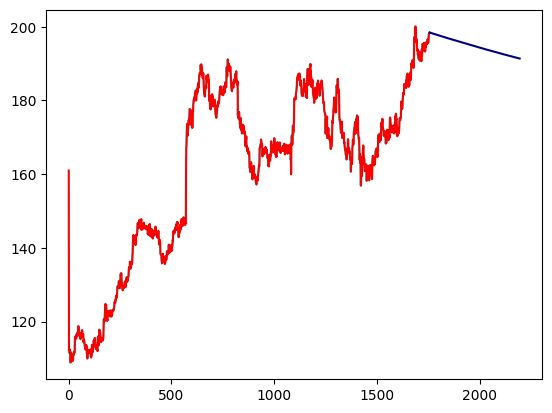

In [49]:
plt.plot(ls1, original_vals, color = 'aqua')
plt.plot(ls1, predicted_vals, color = 'red')
plt.plot(ls2, flist, color = 'navy')

In [50]:
# That particular frequency (peak) has a higher magnitude, so that frequency contributes significantly

In [51]:
# plt.plot(rl_df, color = 'blue')
# plt.plot(results.fittedvalues, color = 'yellow')

In [52]:
# I decided to plot a periodogram in order to further investigate any seasonality in the data
f, Pxx_den = periodogram(rl_df['Open']) # Anything above two times above the original frequency

<function matplotlib.pyplot.show(close=None, block=None)>

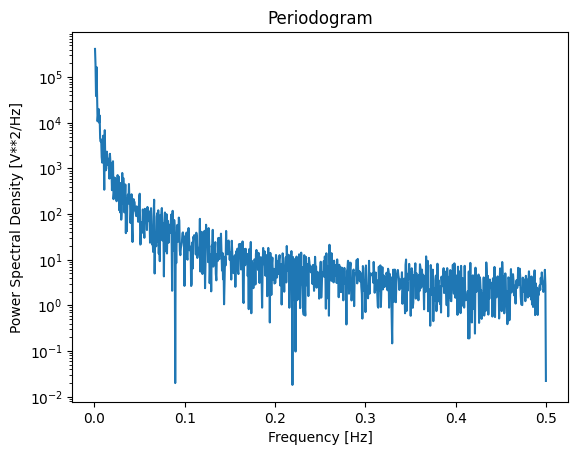

In [53]:
plt.figure()
plt.semilogy(f[1:], Pxx_den[1:]) # Semi logarithmic y
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('Periodogram')
plt.show

In [54]:
data_array = np.array([ls1, predicted_vals, original_vals])

In [55]:
data_array.shape

(3, 1756)

In [56]:
database = pd.DataFrame(data_array.T)

In [57]:
database.rename(columns = {0:'timestamp', 1: 'prediction', 2: 'actual_values'}, inplace = True)

In [58]:
database

,timestamp,prediction,actual_values
0,1.0,160.976487,112.230003
1,2.0,112.253185,112.559998
2,3.0,112.584761,112.300003
3,4.0,112.319059,111.709999
4,5.0,111.735865,111.375000
...,...,...,...
1751,1752.0,196.773602,197.899994
1752,1753.0,197.870803,198.139999
1753,1754.0,198.134590,198.300003
1754,1755.0,198.273374,198.220001


In [59]:
# Using SQLite to save this dataframe into a database
conn = sqlite3.connect('rl.db')
database.to_sql('rl_data', conn, if_exists = 'replace', index = False)

pd.read_sql('SELECT * FROM rl_data', conn)



,timestamp,prediction,actual_values
0,1.0,160.976487,112.230003
1,2.0,112.253185,112.559998
2,3.0,112.584761,112.300003
3,4.0,112.319059,111.709999
4,5.0,111.735865,111.375000
...,...,...,...
1751,1752.0,196.773602,197.899994
1752,1753.0,197.870803,198.139999
1753,1754.0,198.134590,198.300003
1754,1755.0,198.273374,198.220001


In [60]:
# What types of stocks display seasonality?

# Exogenous factors can affect the model

# Random forest regressor, theta predictor, prophet 

# San Francisco traffic

# Fast Fourier Transform the model too